<a href="https://colab.research.google.com/github/bdstel/Machine-Learning/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kaggle Username: **bradensteller**

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV, GridSearchCV, train_test_split

In [ ]:
train_data = pd.read_csv("/content/train.csv").drop(columns = ['id'])
test_data = pd.read_csv("/content/test.csv").drop(columns = ['id'])

In [ ]:
train_data

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,14.48,21.46,94.25,648.2,0.09444,0.09947,0.120400,0.04938,0.2075,0.05636,0.4204,2.2200,3.301,38.87,0.009369,0.029830,0.05371,0.017610,0.02418,0.003249,16.21,29.25,108.40,808.9,0.1306,0.19760,0.33490,0.12250,0.3020,0.06846,1
1,14.92,14.93,96.45,686.9,0.08098,0.08549,0.055390,0.03221,0.1687,0.05669,0.2446,0.4334,1.826,23.31,0.003271,0.017700,0.02310,0.008399,0.01148,0.002379,17.18,18.22,112.00,906.6,0.1065,0.27910,0.31510,0.11470,0.2688,0.08273,0
2,12.81,13.06,81.29,508.8,0.08739,0.03774,0.009193,0.01330,0.1466,0.06133,0.2889,0.9899,1.778,21.79,0.008534,0.006364,0.00618,0.007408,0.01065,0.003351,13.63,16.15,86.70,570.7,0.1162,0.05445,0.02758,0.03990,0.1783,0.07319,0
3,13.20,17.43,84.13,541.6,0.07215,0.04524,0.043360,0.01105,0.1487,0.05635,0.1630,1.6010,0.873,13.56,0.006261,0.015690,0.03079,0.005383,0.01962,0.002250,13.94,27.82,88.28,602.0,0.1101,0.15080,0.22980,0.04970,0.2767,0.07198,0
4,12.47,17.31,80.45,480.1,0.08928,0.07630,0.036090,0.02369,0.1526,0.06046,0.1532,0.7810,1.253,11.91,0.003796,0.013710,0.01346,0.007096,0.01536,0.001541,14.06,24.34,92.82,607.3,0.1276,0.25060,0.20280,0.10530,0.3035,0.07661,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,15.13,29.81,96.71,719.5,0.08320,0.04605,0.046860,0.02739,0.1852,0.05294,0.4681,1.6270,3.043,45.38,0.006831,0.014270,0.02489,0.009087,0.03151,0.001750,17.26,36.91,110.10,931.4,0.1148,0.09866,0.15470,0.06575,0.3233,0.06165,1
280,25.73,17.46,174.20,2010.0,0.11490,0.23630,0.336800,0.19130,0.1956,0.06121,0.9948,0.8509,7.222,153.10,0.006369,0.042430,0.04266,0.015080,0.02335,0.003385,33.13,23.58,229.30,3234.0,0.1530,0.59370,0.64510,0.27560,0.3690,0.08815,1
281,12.04,28.14,76.85,449.9,0.08752,0.06000,0.023670,0.02377,0.1854,0.05698,0.6061,2.6430,4.099,44.96,0.007517,0.015550,0.01465,0.011830,0.02047,0.003883,13.60,33.33,87.24,567.6,0.1041,0.09726,0.05524,0.05547,0.2404,0.06639,0
282,11.27,15.50,73.38,392.0,0.08365,0.11140,0.100700,0.02757,0.1810,0.07252,0.3305,1.0670,2.569,22.97,0.010380,0.066690,0.09472,0.020470,0.01219,0.012330,12.04,18.93,79.73,450.0,0.1102,0.28090,0.30210,0.08272,0.2157,0.10430,0


# Missing Values

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              284 non-null    float64
 1   texture_mean             284 non-null    float64
 2   perimeter_mean           284 non-null    float64
 3   area_mean                284 non-null    float64
 4   smoothness_mean          284 non-null    float64
 5   compactness_mean         284 non-null    float64
 6   concavity_mean           284 non-null    float64
 7   concave points_mean      284 non-null    float64
 8   symmetry_mean            284 non-null    float64
 9   fractal_dimension_mean   284 non-null    float64
 10  radius_se                284 non-null    float64
 11  texture_se               284 non-null    float64
 12  perimeter_se             284 non-null    float64
 13  area_se                  284 non-null    float64
 14  smoothness_se            2

The output shows us that there are no missing values within the data set, because all of the columns display all rows as non-null

# Outliers

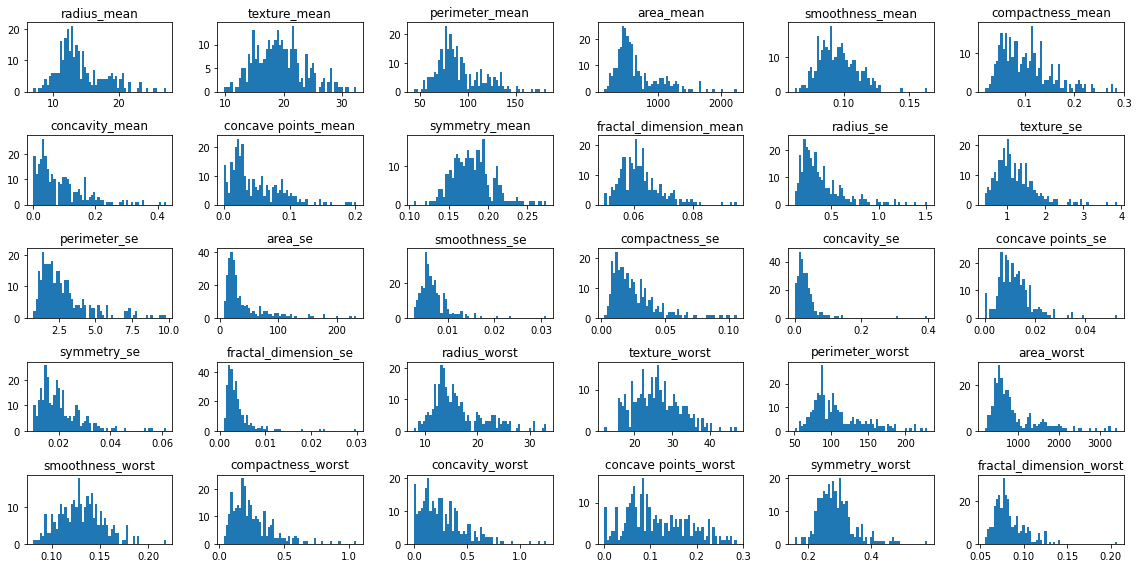

In [ ]:
train_data.iloc[:, :-1].hist(bins = 60, figsize = (16, 8), grid = False, layout = (5, 6))
plt.tight_layout()
plt.show()

Looking at the above data, a lot of the training data seems to be right skewed, however I don't believe that any of these features need to be clamped based on the fact that they all appear to have some level of significance, as they show the mean, best, and worst of each metric.

If I were to clamp these values, there could be a clamped value from the worst category that would align to a non-clamped value from the best, for example. Because of this, I will not be doing anything about the outliers.

# Base Model

There are multiple different Naive Bayes models to choose from in order to predict the data, so it's best to use a base model to see how each of these models lands.

In [ ]:
def train_model(data, model):
  X = data.drop(columns = ['diagnosis'])
  y = data['diagnosis']

  roc_dist = []
  f1_dist = []
  acc_dist = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    model.fit(X_train, y_train)

    predict_prob = model.predict_proba(X_test)[:, 1]
    predict = model.predict(X_test)

    roc_dist.append(roc_auc_score(y_test, predict_prob))
    f1_dist.append(f1_score(y_test, predict))
    acc_dist.append(accuracy_score(y_test, predict))

  roc_dist = np.array(roc_dist)
  f1_dist = np.array(f1_dist)
  acc_dist = np.array(acc_dist)

  scores_df = pd.DataFrame([roc_dist, f1_dist, acc_dist], index = ['ROC AUC', 'F1', 'Accuracy']).transpose()

  scores_df.hist(bins = 20, grid = False, figsize = (22, 4), layout = (1, 3))
  plt.show()

The function above should now work so that it takes in the training data and predicts on it 100 times, and then displays a distribution of each scoring metric.

Now, we use this on the different types of Naive Bayes models

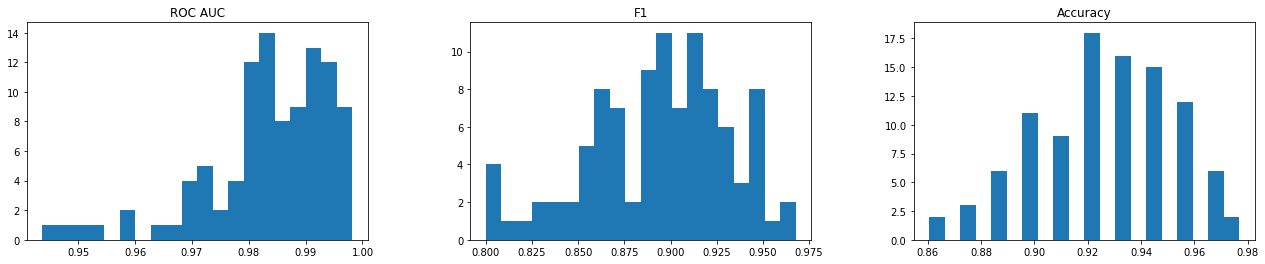

In [ ]:
# Gaussian Naive Bayes
train_model(train_data, GaussianNB())

The Gaussian model gave us an F1 metric averaging around 0.90

This makes sense, as while the data appears right skewed, most of the training data otherwise appears to follow a normal distribution as shown by the histograms from the outlier testing.

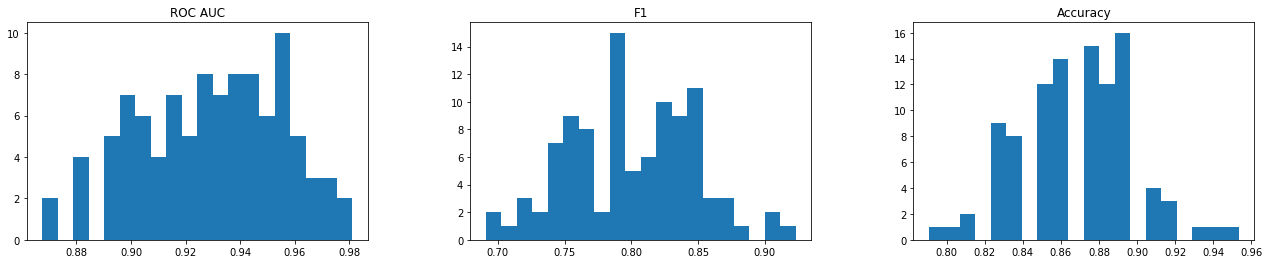

In [ ]:
# Multinomial Naive Bayes
train_model(train_data, MultinomialNB())

Compared to the Gaussian model, the Multinomial model gave us an F1 score around 0.80, which is significantly worse.

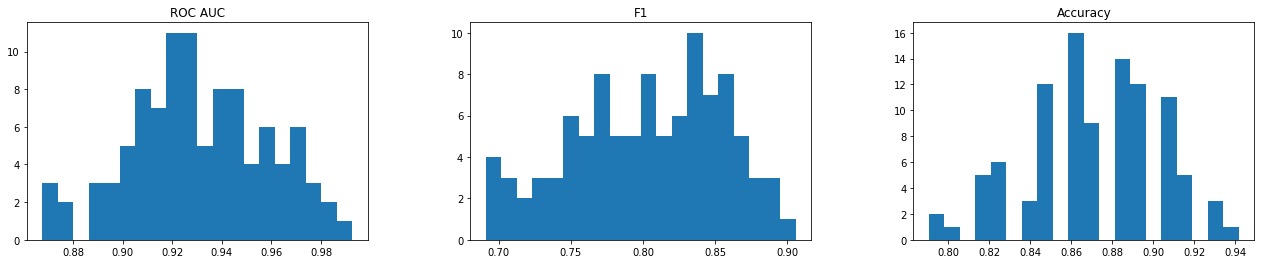

In [ ]:
# Complement Naive Bayes
train_model(train_data, ComplementNB())

While Complement model appears to be a better option than the Multinomial, it is still worse than the Gaussian model with an average F1 of around 0.82

Looking at all of the sample distributions above, I can see that the best Naive Bayes model to use in this case would be the Gaussian model.

The algorithm used in the Gaussian Naive Bayes model assumes that the data follows a normal distribution, because it takes the observation values and finds the probability density of them by plugging them into the equation for a normal distribution. While the training data doesn't necessarily follow a normal distribution (because it is somewhat right-skewed), this appears to be the best assumption for which distribution the data follows.

# Model Training

As discussed above, I will train the Gaussian Naive Bayes model using the training data

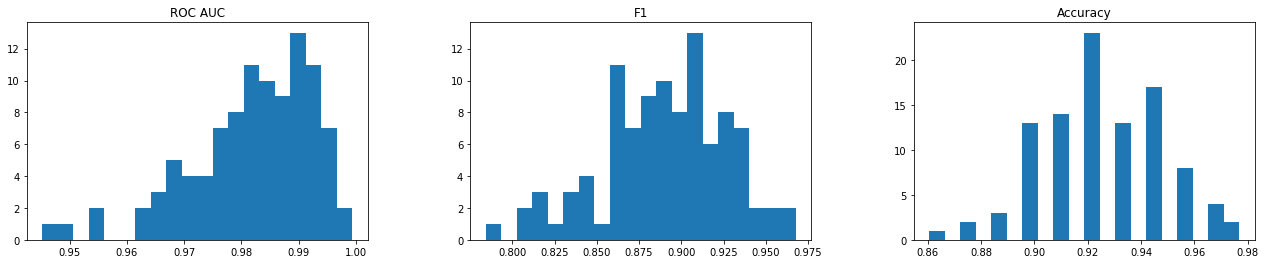

In [ ]:
nb = GaussianNB()
train_model(train_data, nb)

Now that the model is trained, it can be used to predict on the test data.

In [ ]:
final_test_X = test_data

X = train_data.drop(columns = ['diagnosis'])
y = train_data['diagnosis']

nb.fit(X, y)
predictions = nb.predict(final_test_X)

output = pd.DataFrame({'id': np.arange(0, 285), 'diagnosis': predictions})
output = output.set_index('id')
print(output)
output.to_csv('my_submission.csv')

     diagnosis
id            
0            0
1            0
2            0
3            1
4            1
..         ...
280          0
281          1
282          0
283          0
284          1

[285 rows x 1 columns]
